# Nokappa (kappa=1) Optimization Grid Search

**Phase A**: Search over LR, scheduler, epochs, clipping at fixed w=1e-4.  
**Phase B** (separate): Sweep w with the winning recipe from Phase A.

All configs train on **batch 0** (10k patients) with `learn_kappa=False`.

## Metrics tracked per epoch
- `loss`: total training loss (NLL + GP prior)
- `nll`: data NLL only
- `gp_loss`: GP prior only
- `mean_abs_gamma`: genetic effect magnitude
- `mean_abs_delta`: individual residual magnitude
- `mean_abs_Ggamma`: genetic contribution to lambda
- `delta_over_Ggamma`: ratio (lower = genetics explain more)
- `corr_delta_Ggamma`: correlation between delta and G@gamma (negative = compensating)
- `psi_range`: max(psi) - min(psi)

In [ ]:
import sys
import time
import csv
import json
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

sys.path.insert(0, str(Path('../pyScripts_forPublish').resolve()))
from clust_huge_amp_vectorized_reparam import (
    AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest,
    subset_data,
)

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

OUTPUT_DIR = Path('grid_results')
OUTPUT_DIR.mkdir(exist_ok=True)
print('Ready')

Ready


## 1. Config Definitions

| # | Name | LR | Schedule | Epochs | Clip | Patience | Key Idea |
|---|------|-----|----------|--------|------|----------|----------|
| 1 | nok_lr01_200 | 0.1 | none | 200 | - | 75 | v1-style baseline |
| 2 | nok_lr01_300 | 0.1 | none | 300 | - | 75 | More epochs |
| 3 | nok_lr01_500 | 0.1 | none | 500 | - | 75 | Even more |
| 4 | nok_lr01_cos300 | 0.1 | cosine | 300 | - | 75 | Cosine schedule |
| 5 | nok_lr01_cos500 | 0.1 | cosine | 500 | - | 75 | Cosine + more |
| 6 | nok_lr005_300 | 0.05 | none | 300 | - | 75 | Lower LR |
| 7 | nok_lr02_200 | 0.2 | none | 200 | - | 75 | Higher LR |
| 8 | nok_lr01_clip300 | 0.1 | none | 300 | 5.0 | 75 | With clipping |

In [ ]:
CONFIGS = {
    'nok_lr01_200':    {'lr': 0.1,  'scheduler': 'none',   'epochs': 200, 'clip': None, 'patience': 75, 'desc': 'v1-style baseline'},
    'nok_lr01_300':    {'lr': 0.1,  'scheduler': 'none',   'epochs': 300, 'clip': None, 'patience': 75, 'desc': 'More epochs'},
    'nok_lr01_500':    {'lr': 0.1,  'scheduler': 'none',   'epochs': 500, 'clip': None, 'patience': 75, 'desc': 'Even more epochs'},
    'nok_lr01_cos300': {'lr': 0.1,  'scheduler': 'cosine', 'epochs': 300, 'clip': None, 'patience': 75, 'desc': 'Cosine schedule'},
    'nok_lr01_cos500': {'lr': 0.1,  'scheduler': 'cosine', 'epochs': 500, 'clip': None, 'patience': 75, 'desc': 'Cosine + more'},
    'nok_lr005_300':   {'lr': 0.05, 'scheduler': 'none',   'epochs': 300, 'clip': None, 'patience': 75, 'desc': 'Lower LR'},
    'nok_lr02_200':    {'lr': 0.2,  'scheduler': 'none',   'epochs': 200, 'clip': None, 'patience': 75, 'desc': 'Higher LR'},
    'nok_lr01_clip300':{'lr': 0.1,  'scheduler': 'none',   'epochs': 300, 'clip': 5.0,  'patience': 75, 'desc': 'With clipping'},
}

print(f'{len(CONFIGS)} configs defined')
for name, cfg in CONFIGS.items():
    print(f"  {name}: {cfg['desc']}")

8 configs defined
  nok_lr01_200: v1-style baseline
  nok_lr01_300: More epochs
  nok_lr01_500: Even more epochs
  nok_lr01_cos300: Cosine schedule
  nok_lr01_cos500: Cosine + more
  nok_lr005_300: Lower LR
  nok_lr02_200: Higher LR
  nok_lr01_clip300: With clipping


## 2. Load Data (batch 0: 0-10000)

In [ ]:
data_dir = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/'
covariates_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/baselinagefamh_withpcs.csv'
START, END = 0, 10000

print('Loading data...')
Y = torch.load(data_dir + 'Y_tensor.pt', weights_only=False)
E = torch.load(data_dir + 'E_matrix_corrected.pt', weights_only=False)
G = torch.load(data_dir + 'G_matrix.pt', weights_only=False)
essentials = torch.load(data_dir + 'model_essentials.pt', weights_only=False)

Y_batch, E_batch, G_batch, indices = subset_data(Y, E, G, start_index=START, end_index=END)
del Y  # free memory

fh = pd.read_csv(covariates_path)
sex_col = 'Sex' if 'Sex' in fh.columns else 'sex'
if sex_col == 'Sex':
    sex = fh['Sex'].map({'Female': 0, 'Male': 1}).astype(int).values
else:
    sex = fh['sex'].values
sex_batch = sex[START:END]
pc_columns = [f'f.22009.0.{i}' for i in range(1, 11)]
pcs = fh.iloc[START:END][pc_columns].values
G_with_sex = np.column_stack([G_batch, sex_batch, pcs])

refs = torch.load(data_dir + 'reference_trajectories.pt', weights_only=False)
signature_refs = refs['signature_refs']
del refs
prevalence_t = torch.load(data_dir + 'prevalence_t_corrected.pt', weights_only=False)
initial_psi = torch.load(data_dir + 'initial_psi_400k.pt', weights_only=False)
initial_clusters = torch.load(data_dir + 'initial_clusters_400k.pt', weights_only=False)

data = {
    'Y_batch': Y_batch, 'E_batch': E_batch, 'G_with_sex': G_with_sex,
    'essentials': essentials, 'signature_refs': signature_refs,
    'prevalence_t': prevalence_t, 'initial_psi': initial_psi,
    'initial_clusters': initial_clusters,
}

print(f'Y_batch: {Y_batch.shape}, G_with_sex: {G_with_sex.shape}')
print(f'Disease names: {len(essentials["disease_names"])} diseases')
print('Data loaded.')

Loading data...
Y_batch: torch.Size([10000, 348, 52]), G_with_sex: (10000, 47)
Disease names: 348 diseases
Data loaded.


## 3. Training Function

Includes:
- Early stopping (patience=75, restore best state)
- Per-epoch metrics: loss, NLL, GP, |gamma|, |delta|, |Ggamma|, delta/Ggamma ratio
- **NEW**: `corr_delta_Ggamma` — correlation between delta and G@gamma across patients
  - Negative = delta compensating for gamma (bad: model fighting itself)
  - Zero = clean separation (ideal)
  - Positive = gamma under-predicting, delta reinforcing

In [ ]:
def compute_delta_Ggamma_corr(model):
    """Correlation between delta[:,k,t] and (G@gamma)[:,k] averaged over k,t.
    Uses model.G (standardized) to match what flows through the model.
    Returns (corr, n_pairs); corr=nan if no valid pairs (diagnostic for fake 0).
    """
    Ggamma = model.G @ model.gamma  # (N, K_total) - use model's G!
    delta = model.delta.detach()  # (N, K_total, T)
    
    K = model.K
    T = model.T
    corrs = []
    for k in range(K):
        gg_k = Ggamma[:, k]
        gg_centered = gg_k - gg_k.mean()
        gg_std = gg_centered.std().item()
        if gg_std < 1e-8:
            continue
        for t in range(T):
            d_kt = delta[:, k, t]
            d_centered = d_kt - d_kt.mean()
            d_std = d_centered.std().item()
            if d_std < 1e-8:
                continue
            r = (gg_centered * d_centered).mean().item() / (gg_std * d_std)
            corrs.append(r)
    mean_corr = np.mean(corrs) if corrs else np.nan
    return mean_corr, len(corrs)


def train_one_config(config_name, config, data, W=0.0001, K=20):
    """Train one config, return metrics list. Saves checkpoint + CSV."""
    print(f"\n{'='*70}")
    print(f"CONFIG: {config_name} -- {config['desc']}")
    print(f"  LR={config['lr']}, scheduler={config['scheduler']}, "
          f"epochs={config['epochs']}, clip={config['clip']}, patience={config.get('patience')}")
    print(f"{'='*70}")
    
    # Check if already done
    config_dir = OUTPUT_DIR / config_name
    if (config_dir / 'metrics.csv').exists():
        print(f'  Already exists, loading saved results...')
        return pd.read_csv(config_dir / 'metrics.csv').to_dict('records')
    
    # Build model
    torch.manual_seed(42)
    np.random.seed(42)
    
    Y_batch = data['Y_batch']
    model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
        N=Y_batch.shape[0], D=Y_batch.shape[1], T=Y_batch.shape[2],
        K=K, P=data['G_with_sex'].shape[1],
        init_sd_scaler=1e-1, G=data['G_with_sex'], Y=Y_batch,
        genetic_scale=1, W=W, R=0,
        prevalence_t=data['prevalence_t'],
        signature_references=data['signature_refs'],
        healthy_reference=True,
        disease_names=data['essentials']['disease_names'],
        learn_kappa=False,
    )
    
    torch.manual_seed(0)
    np.random.seed(0)
    model.initialize_params(true_psi=data['initial_psi'])
    model.clusters = data['initial_clusters']
    
    # Optimizer
    lr = config['lr']
    param_groups = [
        {'params': [model.delta],   'lr': lr},
        {'params': [model.epsilon], 'lr': lr * 0.1},
        {'params': [model.psi],     'lr': lr * 0.1},
        {'params': [model.gamma],   'lr': lr},
    ]
    optimizer = optim.Adam(param_groups)
    
    scheduler = None
    if config['scheduler'] == 'cosine':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=config['epochs'], eta_min=lr * 0.01
        )
    
    all_params = [model.delta, model.epsilon, model.psi, model.gamma]
    
    # Early stopping
    patience = config.get('patience', None)
    best_loss = float('inf')
    best_state = None
    epochs_no_improve = 0
    
    metrics = []
    t0 = time.time()
    stopped_early = False
    
    for epoch in range(config['epochs']):
        optimizer.zero_grad()
        loss = model.compute_loss(data['E_batch'])
        
        if torch.isnan(loss):
            print(f'  Epoch {epoch}: NaN loss, stopping')
            break
        
        loss.backward()
        
        if config['clip'] is not None:
            torch.nn.utils.clip_grad_norm_(all_params, max_norm=config['clip'])
        
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        cur_loss = loss.item()
        
        # Early stopping
        if patience is not None:
            if cur_loss < best_loss - 1e-4:
                best_loss = cur_loss
                best_state = {k: v.clone() for k, v in model.state_dict().items()}
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f'  Epoch {epoch}: early stopping (patience={patience}), best_loss={best_loss:.2f}')
                    stopped_early = True
                    model.load_state_dict(best_state)
                    break
        
        # Log metrics every 10 epochs
        if epoch % 10 == 0 or epoch == config['epochs'] - 1:
            with torch.no_grad():
                gamma_mag = model.gamma.abs().mean().item()
                delta_mag = model.delta.abs().mean().item()
                Ggamma = model.G @ model.gamma
                Ggamma_mag = Ggamma.abs().mean().item()
                ratio = delta_mag / max(Ggamma_mag, 1e-8)
                psi_vals = model.psi.detach()
                psi_range = (psi_vals.max() - psi_vals.min()).item()
                
                # Delta-Ggamma correlation (use model.G; nan if no valid pairs)
                dg_corr, n_pairs = compute_delta_Ggamma_corr(model)
                
                # Decompose loss: total = NLL + W*gp_loss (avoids E_batch shape mismatch)
                gp_loss = model.compute_gp_prior_loss().item() if W > 0 else 0.0
                nll = cur_loss - W * gp_loss
            
            lr_now = scheduler.get_last_lr()[0] if scheduler else lr
            elapsed = (time.time() - t0) / 60
            
            row = {
                'epoch': epoch, 'loss': cur_loss, 'nll': nll,
                'gp_loss': cur_loss - nll,
                'mean_abs_gamma': gamma_mag,
                'mean_abs_delta': delta_mag,
                'mean_abs_Ggamma': Ggamma_mag,
                'delta_over_Ggamma': ratio,
                'corr_delta_Ggamma': dg_corr,
                'corr_n_pairs': n_pairs,
                'psi_range': psi_range,
                'lr': lr_now,
            }
            metrics.append(row)
            
            if epoch % 50 == 0:
                print(f'  Epoch {epoch:4d}: loss={cur_loss:.2f}, |g|={gamma_mag:.4f}, '
                      f'd/Gg={ratio:.2f}, corr={dg_corr:.3f}, t={elapsed:.1f}m')
    
    elapsed_total = (time.time() - t0) / 60
    stop_info = f' (early stop @ {metrics[-1]["epoch"]})' if stopped_early else ''
    print(f'  Done in {elapsed_total:.1f} min, final loss={metrics[-1]["loss"]:.2f}{stop_info}')
    
    # Save
    config_dir = OUTPUT_DIR / config_name
    config_dir.mkdir(parents=True, exist_ok=True)
    
    csv_path = config_dir / 'metrics.csv'
    with open(csv_path, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=metrics[0].keys())
        writer.writeheader()
        writer.writerows(metrics)
    
    torch.save({
        'model_state_dict': model.state_dict(),
        'config': config, 'config_name': config_name,
        'final_metrics': metrics[-1],
        'stopped_early': stopped_early,
        'best_epoch': metrics[-1]['epoch'] if stopped_early else config['epochs'] - 1,
    }, config_dir / 'checkpoint.pt')
    
    with open(config_dir / 'config.json', 'w') as f:
        json.dump(config, f, indent=2)
    
    print(f'  Saved to {config_dir}/')
    return metrics

print('Training function defined.')

Training function defined.


## 4. Plotting Helper

In [ ]:
def plot_config_metrics(config_name, metrics):
    """Plot loss, |gamma|, delta/Ggamma, and corr(delta, Ggamma) for one config."""
    df = pd.DataFrame(metrics)
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    
    axes[0].plot(df['epoch'], df['loss'], 'b-', linewidth=1.5)
    axes[0].set_title(f'{config_name}: Loss')
    axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(df['epoch'], df['mean_abs_gamma'], 'r-', linewidth=1.5)
    axes[1].set_title(f'{config_name}: |gamma|')
    axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('mean |gamma|')
    axes[1].grid(True, alpha=0.3)
    
    axes[2].plot(df['epoch'], df['delta_over_Ggamma'], 'g-', linewidth=1.5)
    axes[2].set_title(f'{config_name}: delta/Ggamma')
    axes[2].set_xlabel('Epoch'); axes[2].set_ylabel('ratio')
    axes[2].grid(True, alpha=0.3)
    
    axes[3].plot(df['epoch'], df['corr_delta_Ggamma'], 'm-', linewidth=1.5)
    axes[3].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[3].set_title(f'{config_name}: corr(delta, Ggamma)')
    axes[3].set_xlabel('Epoch'); axes[3].set_ylabel('correlation')
    axes[3].set_ylim(-1, 1)
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / config_name / 'loss_curves.png', dpi=120, bbox_inches='tight')
    plt.show()
    
    # Print final metrics
    final = df.iloc[-1]
    print(f"  Final: loss={final['loss']:.2f}, |gamma|={final['mean_abs_gamma']:.4f}, "
          f"d/Gg={final['delta_over_Ggamma']:.2f}, corr={final['corr_delta_Ggamma']:.3f}, "
          f"psi_range={final['psi_range']:.1f}")

print('Plotting function defined.')

Plotting function defined.


---
## 5. Run Configs

Each cell trains one config and plots the result inline. You can run them one at a time or all at once.

### Config 1: nok_lr01_200 (v1-style baseline, LR=0.1, 200 epochs)


CONFIG: nok_lr01_200 -- v1-style baseline
  LR=0.1, scheduler=none, epochs=200, clip=None, patience=75

Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sel

Initializing with 20 disease states + 1 healthy state (REPARAM)
Reparameterized init complete: gamma, psi in NLL path; delta, epsilon have GP prior.
Initializing with 20 disease states + 1 healthy state (REPARAM)
Reparameterized init complete: gamma, psi in NLL path; delta, epsilon have GP prior.


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:245: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


  Epoch    0: loss=62.41, |g|=0.1007, d/Gg=0.04, corr=0.000, t=0.0m
  Epoch   50: loss=60.28, |g|=0.0777, d/Gg=0.02, corr=-0.001, t=1.3m
  Epoch  100: loss=56.21, |g|=0.1108, d/Gg=0.01, corr=-0.001, t=2.5m
  Epoch  150: loss=54.18, |g|=0.1485, d/Gg=0.00, corr=-0.001, t=3.8m
  Done in 5.1 min, final loss=52.00
  Saved to grid_results/nok_lr01_200/


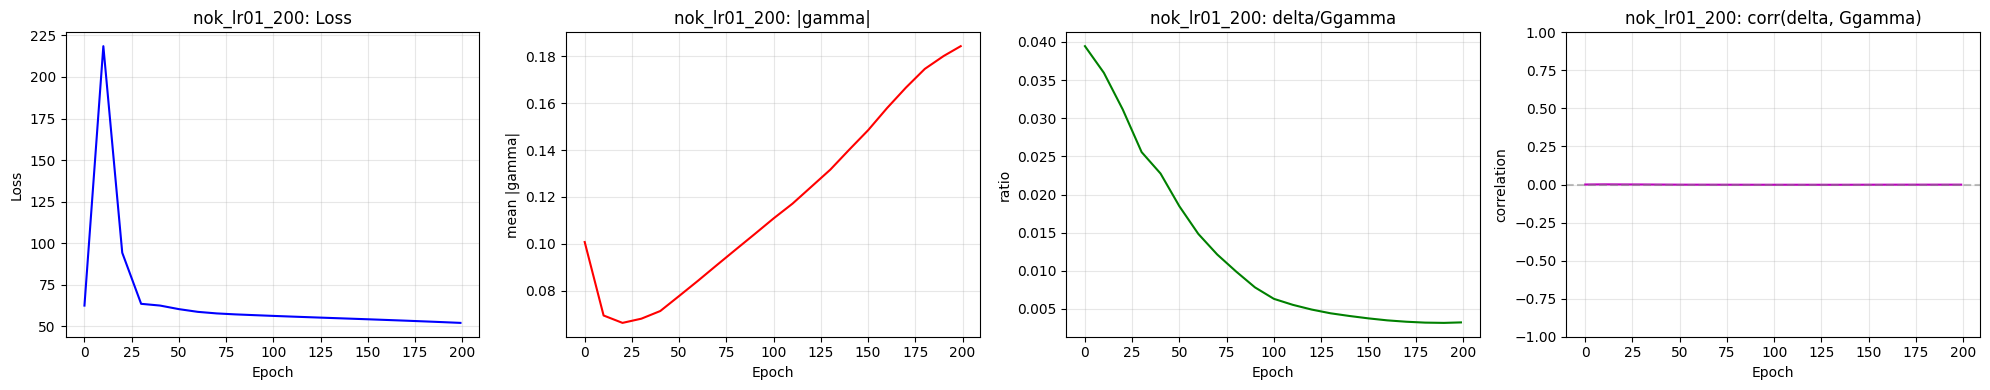

  Final: loss=52.00, |gamma|=0.1843, d/Gg=0.00, corr=-0.001, psi_range=9.3


In [ ]:
m1 = train_one_config('nok_lr01_200', CONFIGS['nok_lr01_200'], data)
plot_config_metrics('nok_lr01_200', m1)

### Config 2: nok_lr01_300 (LR=0.1, 300 epochs)


CONFIG: nok_lr01_300 -- More epochs
  LR=0.1, scheduler=none, epochs=300, clip=None, patience=75

Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sel

Initializing with 20 disease states + 1 healthy state (REPARAM)
Reparameterized init complete: gamma, psi in NLL path; delta, epsilon have GP prior.
Initializing with 20 disease states + 1 healthy state (REPARAM)
Reparameterized init complete: gamma, psi in NLL path; delta, epsilon have GP prior.


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:245: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


  Epoch    0: loss=62.41, |g|=0.1007, d/Gg=0.04, corr=0.000, t=0.0m
  Epoch   50: loss=60.28, |g|=0.0777, d/Gg=0.02, corr=-0.001, t=1.3m
  Epoch  100: loss=56.21, |g|=0.1108, d/Gg=0.01, corr=-0.001, t=2.5m
  Epoch  150: loss=54.18, |g|=0.1485, d/Gg=0.00, corr=-0.001, t=3.7m
  Epoch  200: loss=51.95, |g|=0.1842, d/Gg=0.00, corr=-0.001, t=5.2m
  Epoch  250: loss=49.13, |g|=0.1837, d/Gg=0.00, corr=-0.001, t=6.7m
  Done in 8.1 min, final loss=46.23
  Saved to grid_results/nok_lr01_300/


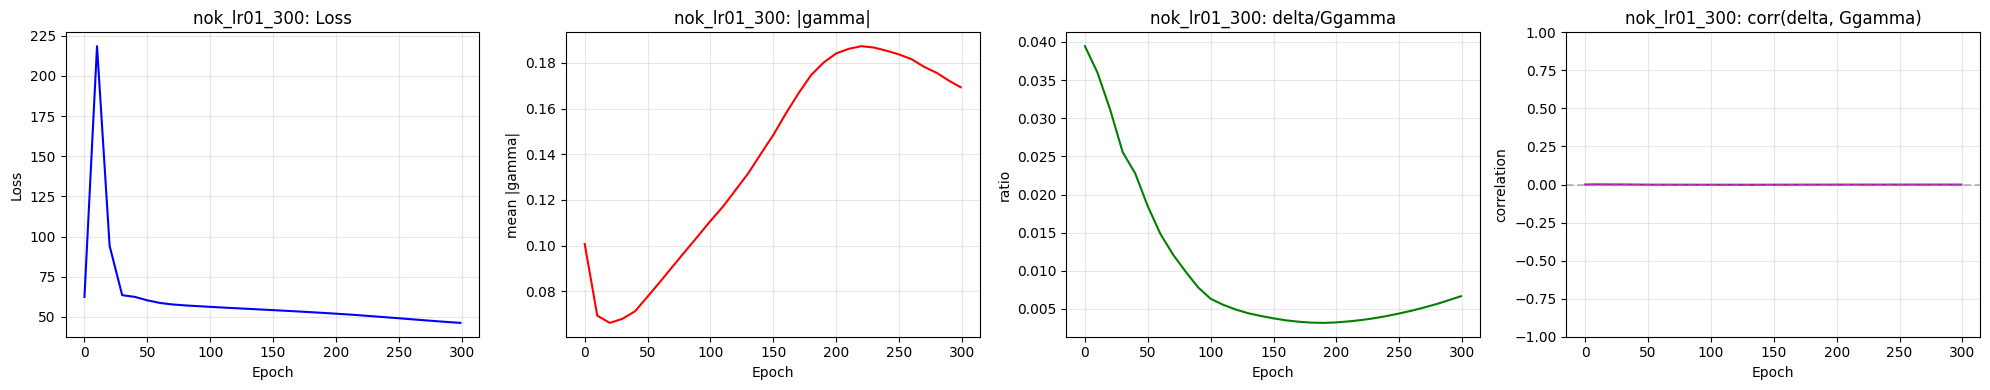

  Final: loss=46.23, |gamma|=0.1693, d/Gg=0.01, corr=-0.000, psi_range=10.7


In [ ]:
m2 = train_one_config('nok_lr01_300', CONFIGS['nok_lr01_300'], data)
plot_config_metrics('nok_lr01_300', m2)

### Config 3: nok_lr01_500 (LR=0.1, 500 epochs)


CONFIG: nok_lr01_500 -- Even more epochs
  LR=0.1, scheduler=none, epochs=500, clip=None, patience=75

Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sel

Initializing with 20 disease states + 1 healthy state (REPARAM)
Reparameterized init complete: gamma, psi in NLL path; delta, epsilon have GP prior.
Initializing with 20 disease states + 1 healthy state (REPARAM)
Reparameterized init complete: gamma, psi in NLL path; delta, epsilon have GP prior.


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:245: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


  Epoch    0: loss=62.41, |g|=0.1007, d/Gg=0.04, corr=0.000, t=0.0m
  Epoch   50: loss=60.28, |g|=0.0777, d/Gg=0.02, corr=-0.001, t=1.4m
  Epoch  100: loss=56.21, |g|=0.1108, d/Gg=0.01, corr=-0.001, t=2.8m
  Epoch  150: loss=54.18, |g|=0.1485, d/Gg=0.00, corr=-0.001, t=4.2m
  Epoch  200: loss=51.95, |g|=0.1842, d/Gg=0.00, corr=-0.001, t=5.6m
  Epoch  250: loss=49.13, |g|=0.1837, d/Gg=0.00, corr=-0.001, t=6.9m
  Epoch  300: loss=46.18, |g|=0.1691, d/Gg=0.01, corr=-0.001, t=8.3m
  Epoch  350: loss=43.91, |g|=0.1545, d/Gg=0.01, corr=-0.000, t=9.7m
  Epoch  400: loss=42.39, |g|=0.1451, d/Gg=0.01, corr=0.000, t=11.1m
  Epoch  450: loss=41.33, |g|=0.1378, d/Gg=0.01, corr=0.000, t=12.5m
  Done in 13.8 min, final loss=40.57
  Saved to grid_results/nok_lr01_500/


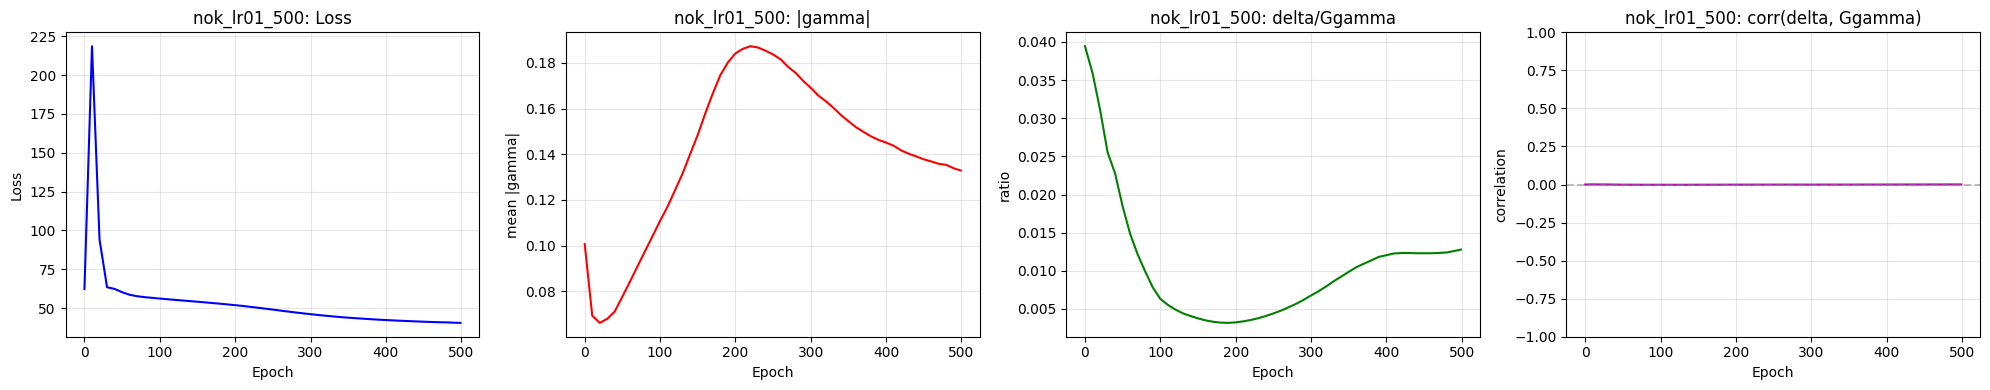

  Final: loss=40.57, |gamma|=0.1329, d/Gg=0.01, corr=0.001, psi_range=12.1


In [ ]:
m3 = train_one_config('nok_lr01_500', CONFIGS['nok_lr01_500'], data)
plot_config_metrics('nok_lr01_500', m3)

### Config 4: nok_lr01_cos300 (LR=0.1, cosine schedule, 300 epochs)


CONFIG: nok_lr01_cos300 -- Cosine schedule
  LR=0.1, scheduler=cosine, epochs=300, clip=None, patience=75

Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sel

Initializing with 20 disease states + 1 healthy state (REPARAM)
Reparameterized init complete: gamma, psi in NLL path; delta, epsilon have GP prior.
Initializing with 20 disease states + 1 healthy state (REPARAM)
Reparameterized init complete: gamma, psi in NLL path; delta, epsilon have GP prior.


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:245: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


  Epoch    0: loss=62.41, |g|=0.1007, d/Gg=0.04, corr=0.000, t=0.0m
  Epoch   50: loss=60.76, |g|=0.0770, d/Gg=0.02, corr=-0.001, t=1.4m
  Epoch  100: loss=56.52, |g|=0.1052, d/Gg=0.01, corr=-0.001, t=2.8m
  Epoch  150: loss=55.11, |g|=0.1288, d/Gg=0.00, corr=-0.002, t=4.1m
  Epoch  200: loss=54.22, |g|=0.1475, d/Gg=0.00, corr=-0.001, t=5.5m
  Epoch  250: loss=53.77, |g|=0.1579, d/Gg=0.00, corr=-0.001, t=6.9m
  Done in 8.2 min, final loss=53.63
  Saved to grid_results/nok_lr01_cos300/


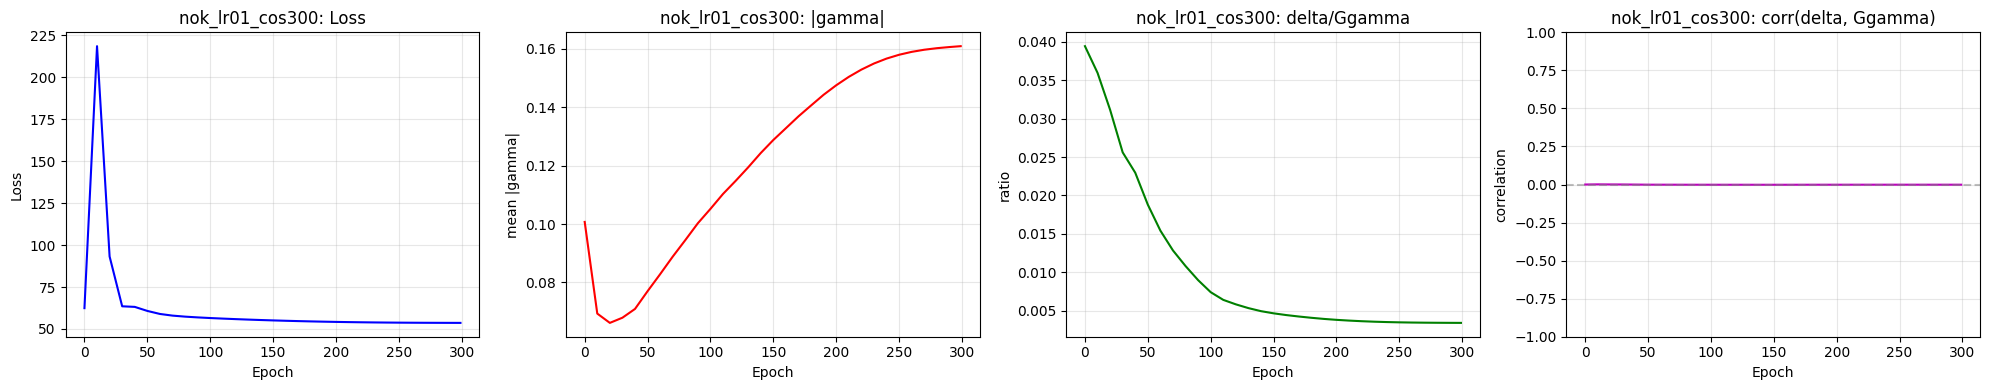

  Final: loss=53.63, |gamma|=0.1609, d/Gg=0.00, corr=-0.001, psi_range=8.8


In [ ]:
m4 = train_one_config('nok_lr01_cos300', CONFIGS['nok_lr01_cos300'], data)
plot_config_metrics('nok_lr01_cos300', m4)

### Config 5: nok_lr01_cos500 (LR=0.1, cosine schedule, 500 epochs)


CONFIG: nok_lr01_cos500 -- Cosine + more
  LR=0.1, scheduler=cosine, epochs=500, clip=None, patience=75

Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sel

Initializing with 20 disease states + 1 healthy state (REPARAM)
Reparameterized init complete: gamma, psi in NLL path; delta, epsilon have GP prior.
Initializing with 20 disease states + 1 healthy state (REPARAM)
Reparameterized init complete: gamma, psi in NLL path; delta, epsilon have GP prior.


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:245: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


  Epoch    0: loss=62.41, |g|=0.1007, d/Gg=0.04, corr=0.000, t=0.0m
  Epoch   50: loss=60.47, |g|=0.0774, d/Gg=0.02, corr=-0.001, t=1.4m
  Epoch  100: loss=56.32, |g|=0.1087, d/Gg=0.01, corr=-0.001, t=2.8m
  Epoch  150: loss=54.53, |g|=0.1407, d/Gg=0.00, corr=-0.001, t=4.2m
  Epoch  200: loss=52.90, |g|=0.1757, d/Gg=0.00, corr=-0.001, t=5.6m
  Epoch  250: loss=51.31, |g|=0.1867, d/Gg=0.00, corr=-0.001, t=7.0m
  Epoch  300: loss=49.85, |g|=0.1815, d/Gg=0.00, corr=-0.001, t=8.4m
  Epoch  350: loss=48.75, |g|=0.1740, d/Gg=0.00, corr=-0.001, t=9.9m
  Epoch  400: loss=48.08, |g|=0.1691, d/Gg=0.01, corr=-0.001, t=11.3m
  Epoch  450: loss=47.73, |g|=0.1670, d/Gg=0.01, corr=-0.001, t=12.6m
  Done in 14.0 min, final loss=47.57
  Saved to grid_results/nok_lr01_cos500/


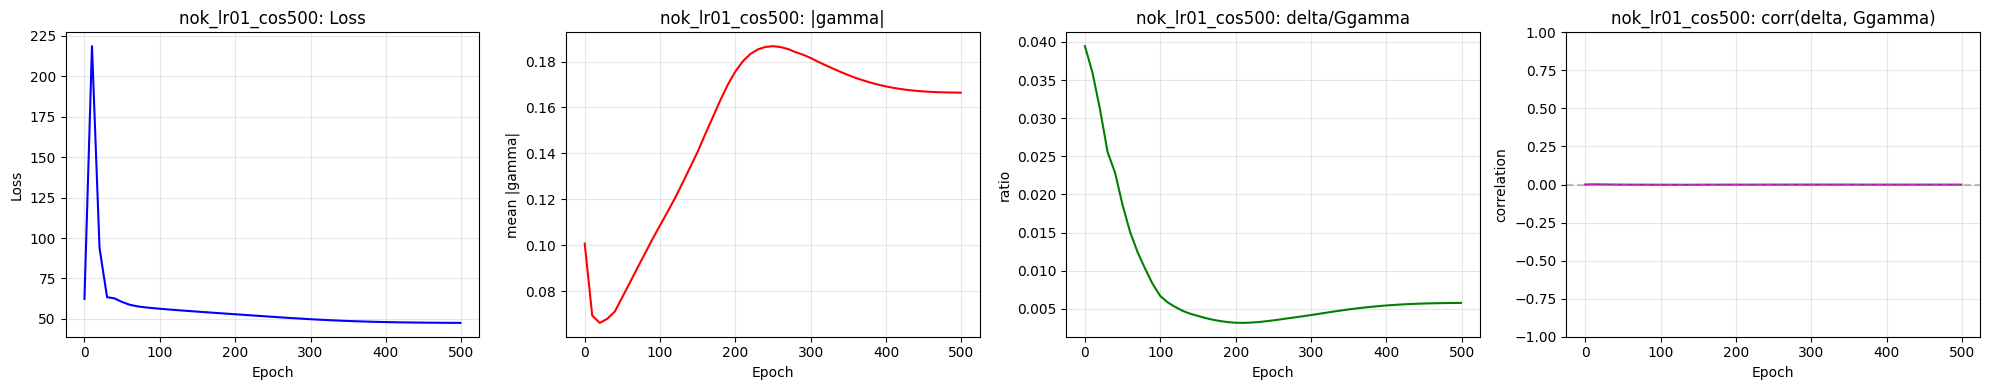

  Final: loss=47.57, |gamma|=0.1664, d/Gg=0.01, corr=-0.001, psi_range=10.4


In [ ]:
m5 = train_one_config('nok_lr01_cos500', CONFIGS['nok_lr01_cos500'], data)
plot_config_metrics('nok_lr01_cos500', m5)

### Config 6: nok_lr005_300 (LR=0.05, 300 epochs)


CONFIG: nok_lr005_300 -- Lower LR
  LR=0.05, scheduler=none, epochs=300, clip=None, patience=75

Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sel

Initializing with 20 disease states + 1 healthy state (REPARAM)
Reparameterized init complete: gamma, psi in NLL path; delta, epsilon have GP prior.
Initializing with 20 disease states + 1 healthy state (REPARAM)
Reparameterized init complete: gamma, psi in NLL path; delta, epsilon have GP prior.


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:245: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


  Epoch    0: loss=62.41, |g|=0.0531, d/Gg=0.06, corr=-0.000, t=0.0m
  Epoch   50: loss=60.07, |g|=0.0641, d/Gg=0.03, corr=-0.000, t=1.4m
  Epoch  100: loss=57.40, |g|=0.0803, d/Gg=0.02, corr=-0.001, t=2.8m
  Epoch  150: loss=55.26, |g|=0.1064, d/Gg=0.01, corr=-0.001, t=4.3m
  Epoch  200: loss=53.34, |g|=0.1413, d/Gg=0.00, corr=-0.001, t=5.7m
  Epoch  250: loss=51.57, |g|=0.2029, d/Gg=0.00, corr=-0.001, t=7.1m
  Done in 8.4 min, final loss=49.80
  Saved to grid_results/nok_lr005_300/


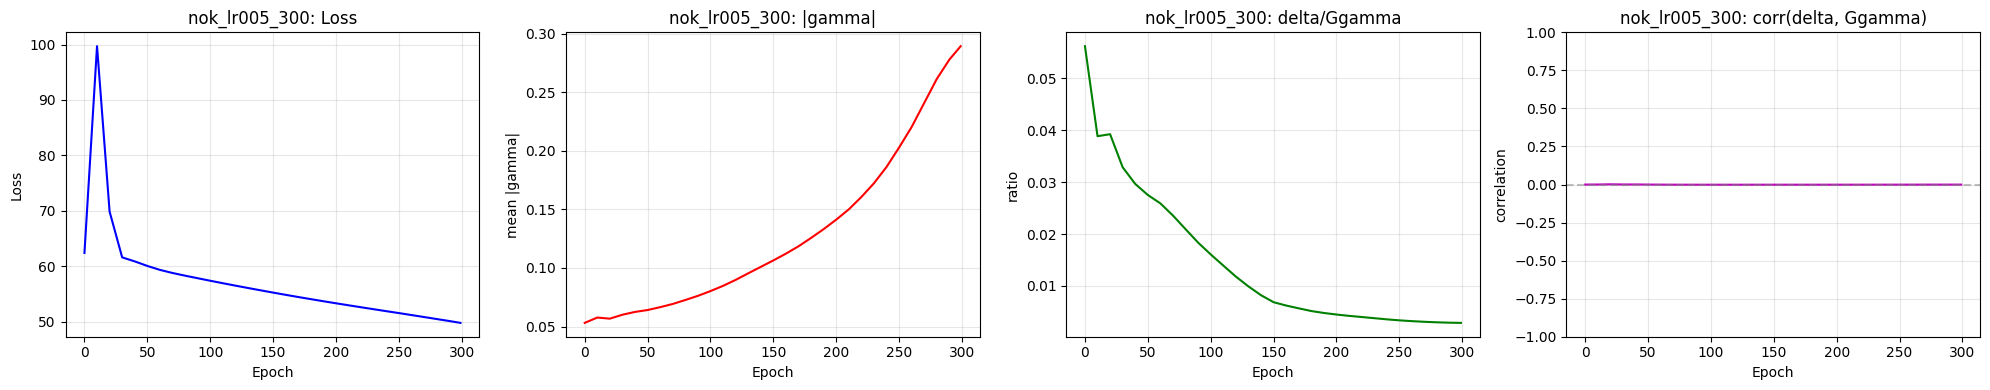

  Final: loss=49.80, |gamma|=0.2895, d/Gg=0.00, corr=-0.001, psi_range=8.9


In [ ]:
m6 = train_one_config('nok_lr005_300', CONFIGS['nok_lr005_300'], data)
plot_config_metrics('nok_lr005_300', m6)

### Config 7: nok_lr02_200 (LR=0.2, 200 epochs)


CONFIG: nok_lr02_200 -- Higher LR
  LR=0.2, scheduler=none, epochs=200, clip=None, patience=75

Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sel

Initializing with 20 disease states + 1 healthy state (REPARAM)
Reparameterized init complete: gamma, psi in NLL path; delta, epsilon have GP prior.
Initializing with 20 disease states + 1 healthy state (REPARAM)
Reparameterized init complete: gamma, psi in NLL path; delta, epsilon have GP prior.


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:245: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


  Epoch    0: loss=62.41, |g|=0.1960, d/Gg=0.17, corr=0.000, t=0.0m
  Epoch   50: loss=64.65, |g|=0.1246, d/Gg=0.08, corr=-0.001, t=1.5m
  Epoch  100: loss=55.62, |g|=0.1481, d/Gg=0.07, corr=0.000, t=3.2m
  Epoch  150: loss=53.02, |g|=0.1586, d/Gg=0.07, corr=0.001, t=5.1m
  Done in 6.9 min, final loss=49.37
  Saved to grid_results/nok_lr02_200/


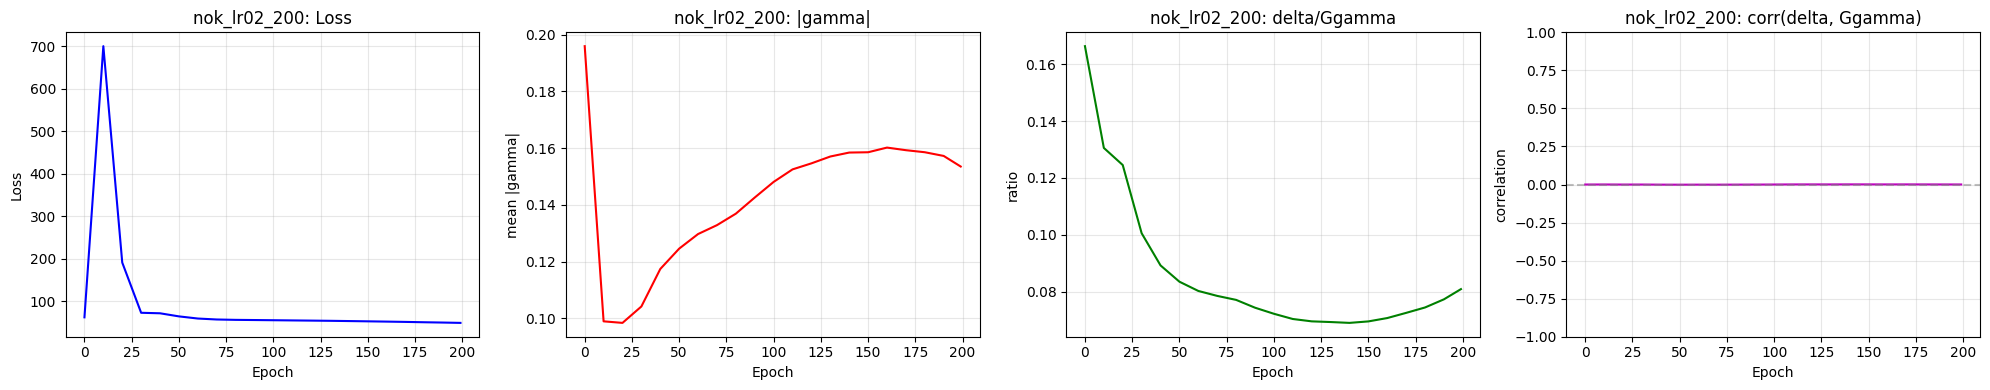

  Final: loss=49.37, |gamma|=0.1535, d/Gg=0.08, corr=0.000, psi_range=11.3


In [ ]:
m7 = train_one_config('nok_lr02_200', CONFIGS['nok_lr02_200'], data)
plot_config_metrics('nok_lr02_200', m7)

### Config 8: nok_lr01_clip300 (LR=0.1, grad clipping=5.0, 300 epochs)


CONFIG: nok_lr01_clip300 -- With clipping
  LR=0.1, scheduler=none, epochs=300, clip=5.0, patience=75

Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sel

Initializing with 20 disease states + 1 healthy state (REPARAM)
Reparameterized init complete: gamma, psi in NLL path; delta, epsilon have GP prior.
Initializing with 20 disease states + 1 healthy state (REPARAM)
Reparameterized init complete: gamma, psi in NLL path; delta, epsilon have GP prior.


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:245: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


  Epoch    0: loss=62.41, |g|=0.1007, d/Gg=0.04, corr=0.000, t=0.0m
  Epoch   50: loss=60.28, |g|=0.0777, d/Gg=0.02, corr=-0.001, t=1.5m
  Epoch  100: loss=56.21, |g|=0.1108, d/Gg=0.01, corr=-0.001, t=3.0m
  Epoch  150: loss=54.18, |g|=0.1485, d/Gg=0.00, corr=-0.001, t=4.5m
  Epoch  200: loss=51.95, |g|=0.1842, d/Gg=0.00, corr=-0.001, t=6.0m
  Epoch  250: loss=49.13, |g|=0.1837, d/Gg=0.00, corr=-0.001, t=7.5m
  Done in 9.0 min, final loss=46.23
  Saved to grid_results/nok_lr01_clip300/


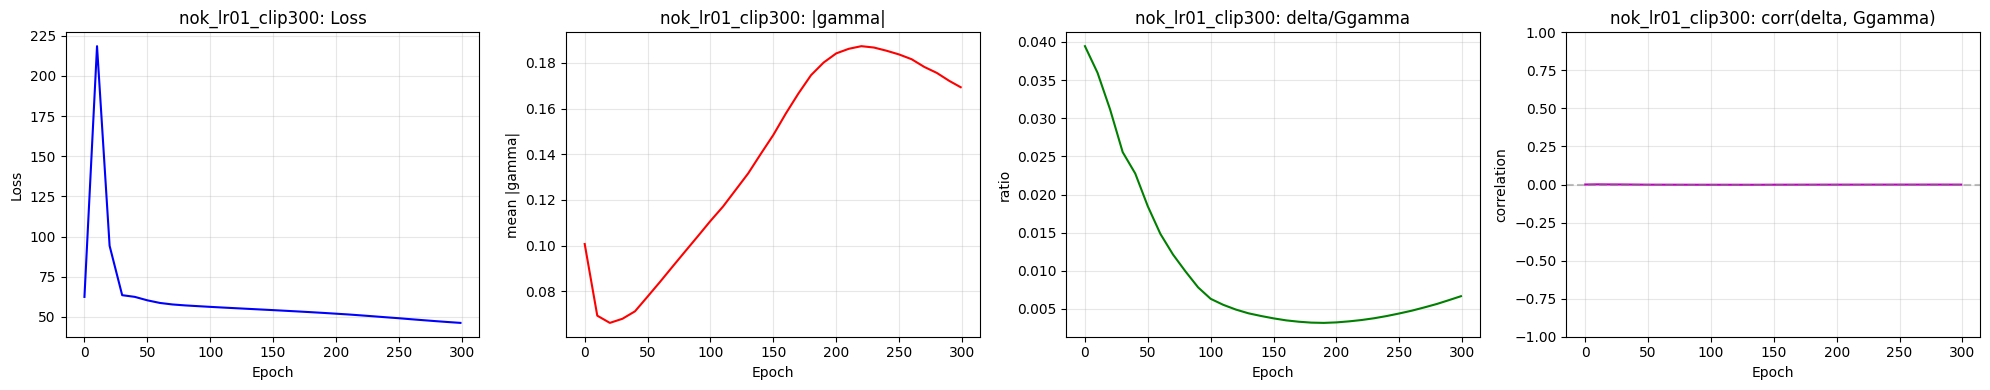

  Final: loss=46.23, |gamma|=0.1693, d/Gg=0.01, corr=-0.000, psi_range=10.7


In [ ]:
m8 = train_one_config('nok_lr01_clip300', CONFIGS['nok_lr01_clip300'], data)
plot_config_metrics('nok_lr01_clip300', m8)

---
## 6. Comparison: All Configs Overlaid

Summary table + overlay plots for loss, |gamma|, delta/Ggamma, and corr(delta, Ggamma).

In [ ]:
# Load all results
all_results = {}
for name in CONFIGS:
    csv_path = OUTPUT_DIR / name / 'metrics.csv'
    if csv_path.exists():
        all_results[name] = pd.read_csv(csv_path)

print(f'Loaded {len(all_results)} configs')

# Summary table
print(f"\n{'CONFIG':<22} {'LR':>5} {'SCHED':>7} {'EP':>4} {'CLIP':>5} "
      f"{'LOSS':>8} {'|gamma|':>8} {'d/Gg':>6} {'corr':>6} {'psi_rng':>8}")
print('-' * 95)

for name in sorted(all_results):
    df = all_results[name]
    m = df.iloc[-1]
    c = CONFIGS[name]
    clip_str = f"{c['clip']}" if c['clip'] else 'none'
    corr_val = m.get('corr_delta_Ggamma', float('nan'))
    print(f"{name:<22} {c['lr']:>5.3f} {c['scheduler']:>7} {c['epochs']:>4} "
          f"{clip_str:>5} {m['loss']:>8.2f} {m['mean_abs_gamma']:>8.4f} "
          f"{m['delta_over_Ggamma']:>6.2f} {corr_val:>6.3f} {m['psi_range']:>8.1f}")

Loaded 8 configs

CONFIG                    LR   SCHED   EP  CLIP     LOSS  |gamma|   d/Gg   corr  psi_rng
-----------------------------------------------------------------------------------------------
nok_lr005_300          0.050    none  300  none    49.80   0.2895   0.00 -0.001      8.9
nok_lr01_200           0.100    none  200  none    52.00   0.1843   0.00 -0.001      9.3
nok_lr01_300           0.100    none  300  none    46.23   0.1693   0.01 -0.000     10.7
nok_lr01_500           0.100    none  500  none    40.57   0.1329   0.01  0.001     12.1
nok_lr01_clip300       0.100    none  300   5.0    46.23   0.1693   0.01 -0.000     10.7
nok_lr01_cos300        0.100  cosine  300  none    53.63   0.1609   0.00 -0.001      8.8
nok_lr01_cos500        0.100  cosine  500  none    47.57   0.1664   0.01 -0.001     10.4
nok_lr02_200           0.200    none  200  none    49.37   0.1535   0.01 -0.001     11.3


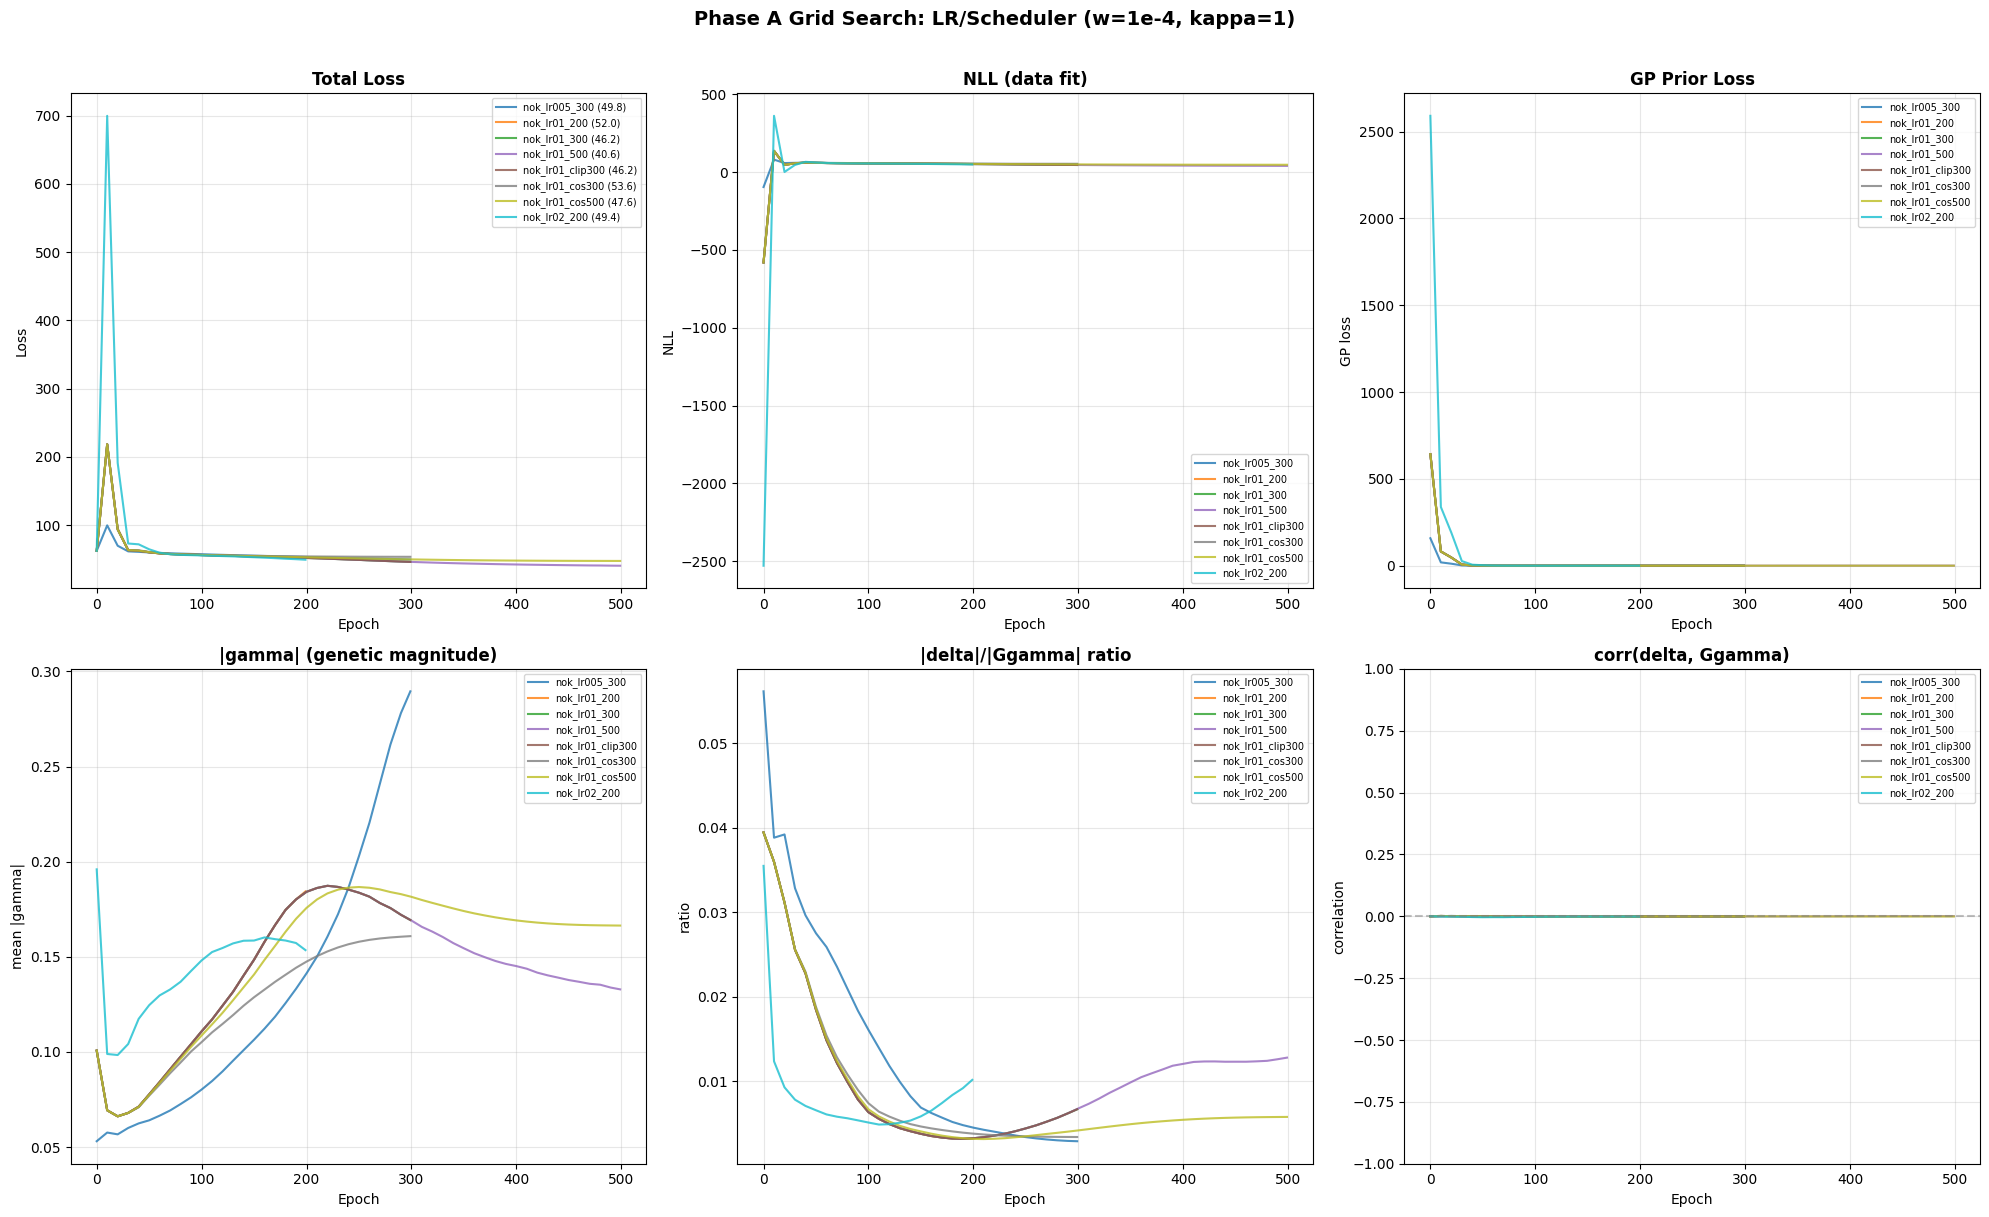

Saved: grid_results/comparison.png


In [ ]:
# Overlay plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
colors = plt.cm.tab10(np.linspace(0, 1, len(all_results)))

for i, (name, df) in enumerate(sorted(all_results.items())):
    c = colors[i]
    lbl = f"{name} ({df['loss'].iloc[-1]:.1f})"
    
    axes[0, 0].plot(df['epoch'], df['loss'], color=c, label=lbl, linewidth=1.5, alpha=0.8)
    axes[0, 1].plot(df['epoch'], df['nll'], color=c, label=name, linewidth=1.5, alpha=0.8)
    axes[0, 2].plot(df['epoch'], df['gp_loss'], color=c, label=name, linewidth=1.5, alpha=0.8)
    axes[1, 0].plot(df['epoch'], df['mean_abs_gamma'], color=c, label=name, linewidth=1.5, alpha=0.8)
    axes[1, 1].plot(df['epoch'], df['delta_over_Ggamma'], color=c, label=name, linewidth=1.5, alpha=0.8)
    if 'corr_delta_Ggamma' in df.columns:
        axes[1, 2].plot(df['epoch'], df['corr_delta_Ggamma'], color=c, label=name, linewidth=1.5, alpha=0.8)

axes[0, 0].set_title('Total Loss', fontweight='bold'); axes[0, 0].set_ylabel('Loss')
axes[0, 1].set_title('NLL (data fit)', fontweight='bold'); axes[0, 1].set_ylabel('NLL')
axes[0, 2].set_title('GP Prior Loss', fontweight='bold'); axes[0, 2].set_ylabel('GP loss')
axes[1, 0].set_title('|gamma| (genetic magnitude)', fontweight='bold'); axes[1, 0].set_ylabel('mean |gamma|')
axes[1, 1].set_title('|delta|/|Ggamma| ratio', fontweight='bold'); axes[1, 1].set_ylabel('ratio')
axes[1, 2].set_title('corr(delta, Ggamma)', fontweight='bold'); axes[1, 2].set_ylabel('correlation')
axes[1, 2].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1, 2].set_ylim(-1, 1)

for ax in axes.flat:
    ax.set_xlabel('Epoch')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=7)

plt.suptitle('Phase A Grid Search: LR/Scheduler (w=1e-4, kappa=1)', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved: {OUTPUT_DIR / "comparison.png"}')

---
## 8. Phase B: W Sweep

Winner from Phase A: **nok_lr01_300** (loss 46.23). Now sweep GP prior weight W.

W values: 1e-5, 5e-5, 1e-4, 5e-4, 1e-3 (and optionally 1e-2).

In [ ]:
# Phase B: W sweep with nok_lr01_300 recipe
BASE_CONFIG = CONFIGS['nok_lr01_300']  # lr=0.1, 300 epochs, no scheduler, no clip
W_SWEEP = [(1e-5, 'nok_lr01_300_w1em5'), (5e-5, 'nok_lr01_300_w5em5'), (1e-4, 'nok_lr01_300_w1em4'),
           (5e-4, 'nok_lr01_300_w5em4'), (1e-3, 'nok_lr01_300_w1em3'), (1e-2, 'nok_lr01_300_w1em2')]

phase_b_results = {}
for w, name in W_SWEEP:
    print(f"Training {name} (W={w})...")
    m = train_one_config(name, BASE_CONFIG, data, W=w)
    phase_b_results[name] = pd.DataFrame(m)
    print(f"  Done: loss={m[-1]['loss']:.2f}")

Training nok_lr01_300_w1em5 (W=1e-05)...

CONFIG: nok_lr01_300_w1em5 -- More epochs
  LR=0.1, scheduler=none, epochs=300, clip=None, patience=75


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sel


Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases
Initializing with 20 disease states + 1 healthy state (REPARAM)
Reparameterized init complete: gamma, psi in NLL path; delta, epsilon have GP prior.
Initializing with 20 disease states + 1 healthy state (REPARAM)
Reparameterized init complete: gamma, psi in NLL path; delta, epsilon have GP prior.


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:245: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


  Epoch    0: loss=62.32, |g|=0.1007, d/Gg=0.18, corr=0.001, t=0.0m
  Epoch   50: loss=53.71, |g|=0.0936, d/Gg=0.17, corr=-0.001, t=1.5m
  Epoch  100: loss=47.69, |g|=0.1856, d/Gg=0.14, corr=-0.000, t=3.0m
  Epoch  150: loss=42.32, |g|=0.2117, d/Gg=0.16, corr=0.001, t=4.7m
  Epoch  200: loss=39.13, |g|=0.2116, d/Gg=0.20, corr=0.002, t=6.4m
  Epoch  250: loss=37.62, |g|=0.2086, d/Gg=0.22, corr=0.003, t=8.1m
  Done in 9.6 min, final loss=36.73
  Saved to grid_results/nok_lr01_300_w1em5/
  Done: loss=36.73
Training nok_lr01_300_w5em5 (W=5e-05)...

CONFIG: nok_lr01_300_w5em5 -- More epochs
  LR=0.1, scheduler=none, epochs=300, clip=None, patience=75


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sel


Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases
Initializing with 20 disease states + 1 healthy state (REPARAM)
Reparameterized init complete: gamma, psi in NLL path; delta, epsilon have GP prior.
Initializing with 20 disease states + 1 healthy state (REPARAM)
Reparameterized init complete: gamma, psi in NLL path; delta, epsilon have GP prior.


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:245: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


  Epoch    0: loss=62.36, |g|=0.1007, d/Gg=0.19, corr=-0.000, t=0.0m
  Epoch   50: loss=58.53, |g|=0.0792, d/Gg=0.13, corr=0.001, t=1.7m
  Epoch  100: loss=54.27, |g|=0.1237, d/Gg=0.10, corr=0.000, t=3.3m
  Epoch  150: loss=51.23, |g|=0.1816, d/Gg=0.08, corr=0.000, t=4.9m
  Epoch  200: loss=47.70, |g|=0.2032, d/Gg=0.09, corr=0.000, t=6.4m
  Epoch  250: loss=44.19, |g|=0.1858, d/Gg=0.11, corr=0.001, t=7.8m
  Done in 9.4 min, final loss=41.87
  Saved to grid_results/nok_lr01_300_w5em5/
  Done: loss=41.87
Training nok_lr01_300_w1em4 (W=0.0001)...

CONFIG: nok_lr01_300_w1em4 -- More epochs
  LR=0.1, scheduler=none, epochs=300, clip=None, patience=75


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sel


Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases
Initializing with 20 disease states + 1 healthy state (REPARAM)
Reparameterized init complete: gamma, psi in NLL path; delta, epsilon have GP prior.
Initializing with 20 disease states + 1 healthy state (REPARAM)
Reparameterized init complete: gamma, psi in NLL path; delta, epsilon have GP prior.


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:245: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


  Epoch    0: loss=62.41, |g|=0.1007, d/Gg=0.19, corr=-0.001, t=0.0m
  Epoch   50: loss=60.28, |g|=0.0777, d/Gg=0.13, corr=0.001, t=1.6m
  Epoch  100: loss=56.21, |g|=0.1108, d/Gg=0.10, corr=0.001, t=3.2m
  Epoch  150: loss=54.18, |g|=0.1485, d/Gg=0.08, corr=0.000, t=4.8m
  Epoch  200: loss=51.95, |g|=0.1842, d/Gg=0.07, corr=0.001, t=6.3m
  Epoch  250: loss=49.13, |g|=0.1837, d/Gg=0.08, corr=0.001, t=7.8m
  Done in 9.3 min, final loss=46.23
  Saved to grid_results/nok_lr01_300_w1em4/
  Done: loss=46.23
Training nok_lr01_300_w5em4 (W=0.0005)...

CONFIG: nok_lr01_300_w5em4 -- More epochs
  LR=0.1, scheduler=none, epochs=300, clip=None, patience=75


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sel


Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases
Initializing with 20 disease states + 1 healthy state (REPARAM)
Reparameterized init complete: gamma, psi in NLL path; delta, epsilon have GP prior.
Initializing with 20 disease states + 1 healthy state (REPARAM)
Reparameterized init complete: gamma, psi in NLL path; delta, epsilon have GP prior.


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:245: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


  Epoch    0: loss=62.82, |g|=0.1007, d/Gg=0.19, corr=-0.001, t=0.0m
  Epoch   50: loss=68.25, |g|=0.0756, d/Gg=0.13, corr=0.001, t=1.6m
  Epoch  100: loss=58.16, |g|=0.1024, d/Gg=0.10, corr=0.001, t=3.2m
  Epoch  150: loss=57.30, |g|=0.1236, d/Gg=0.08, corr=0.001, t=4.8m
  Epoch  200: loss=56.75, |g|=0.1479, d/Gg=0.06, corr=0.002, t=6.5m
  Epoch  250: loss=56.17, |g|=0.1962, d/Gg=0.05, corr=0.002, t=8.1m
  Done in 9.9 min, final loss=55.50
  Saved to grid_results/nok_lr01_300_w5em4/
  Done: loss=55.50
Training nok_lr01_300_w1em3 (W=0.001)...

CONFIG: nok_lr01_300_w1em3 -- More epochs
  LR=0.1, scheduler=none, epochs=300, clip=None, patience=75


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sel


Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases
Initializing with 20 disease states + 1 healthy state (REPARAM)
Reparameterized init complete: gamma, psi in NLL path; delta, epsilon have GP prior.
Initializing with 20 disease states + 1 healthy state (REPARAM)
Reparameterized init complete: gamma, psi in NLL path; delta, epsilon have GP prior.


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:245: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


  Epoch    0: loss=63.32, |g|=0.1007, d/Gg=0.19, corr=-0.001, t=0.0m
  Epoch   50: loss=77.19, |g|=0.0747, d/Gg=0.13, corr=0.001, t=1.7m
  Epoch  100: loss=58.48, |g|=0.1016, d/Gg=0.10, corr=0.001, t=3.5m
  Epoch  150: loss=57.67, |g|=0.1256, d/Gg=0.07, corr=0.001, t=5.2m
  Epoch  200: loss=57.31, |g|=0.1505, d/Gg=0.06, corr=0.002, t=6.9m
  Epoch  250: loss=57.04, |g|=0.1921, d/Gg=0.05, corr=0.002, t=8.6m
  Done in 10.2 min, final loss=56.78
  Saved to grid_results/nok_lr01_300_w1em3/
  Done: loss=56.78
Training nok_lr01_300_w1em2 (W=0.01)...

CONFIG: nok_lr01_300_w1em2 -- More epochs
  LR=0.1, scheduler=none, epochs=300, clip=None, patience=75


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sel


Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases
Initializing with 20 disease states + 1 healthy state (REPARAM)
Reparameterized init complete: gamma, psi in NLL path; delta, epsilon have GP prior.
Initializing with 20 disease states + 1 healthy state (REPARAM)
Reparameterized init complete: gamma, psi in NLL path; delta, epsilon have GP prior.


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized_reparam.py:245: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


  Epoch    0: loss=72.36, |g|=0.1007, d/Gg=0.19, corr=-0.001, t=0.0m
  Epoch   50: loss=235.87, |g|=0.0756, d/Gg=0.13, corr=0.000, t=1.7m
  Epoch  100: loss=60.02, |g|=0.1020, d/Gg=0.10, corr=0.000, t=3.4m
  Epoch  150: loss=58.29, |g|=0.1301, d/Gg=0.07, corr=0.001, t=5.1m
  Epoch  200: loss=58.36, |g|=0.1660, d/Gg=0.05, corr=0.002, t=6.8m
  Epoch 221: early stopping (patience=75), best_loss=58.28
  Done in 7.5 min, final loss=58.43 (early stop @ 220)
  Saved to grid_results/nok_lr01_300_w1em2/
  Done: loss=58.43


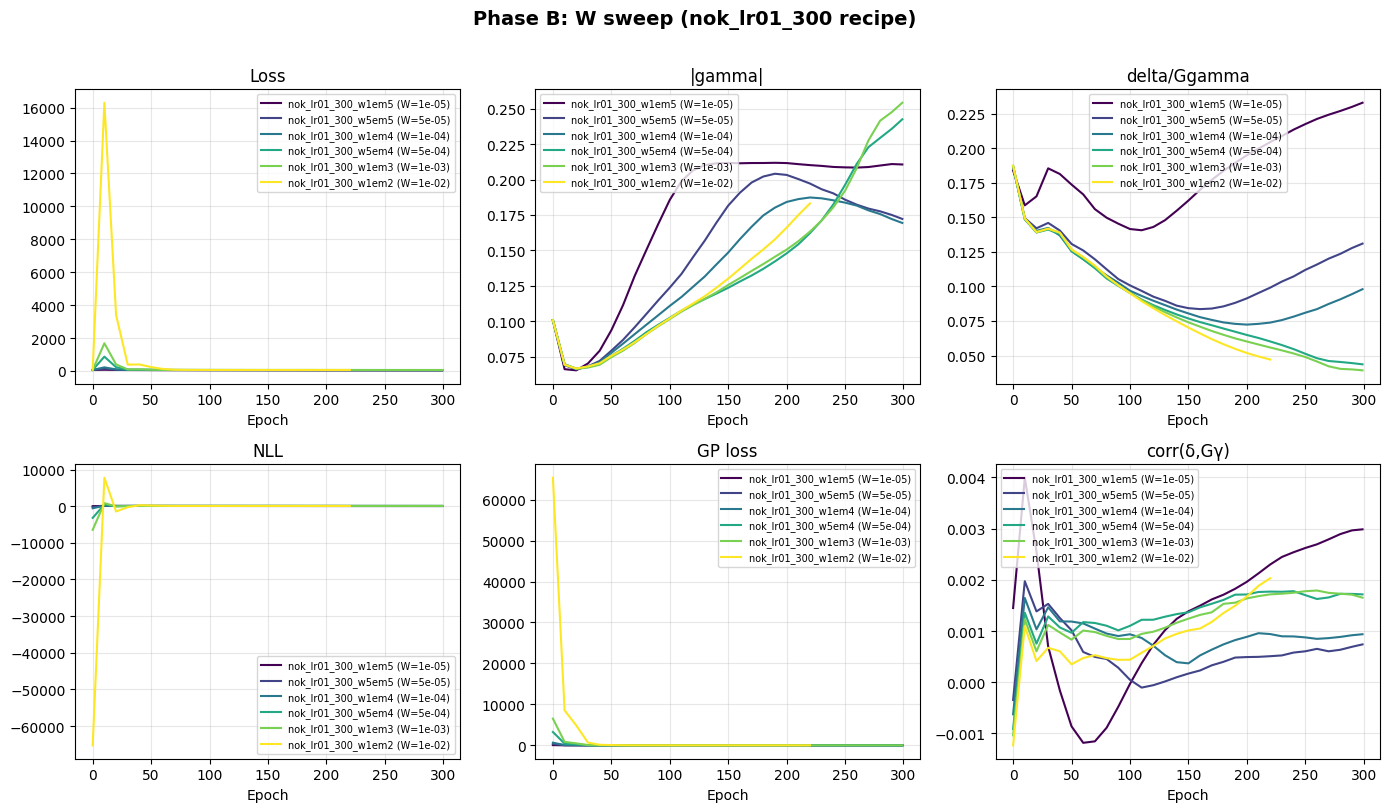

Saved: grid_results/phase_b_w_sweep.png


In [ ]:
# Plot Phase B W-sweep comparison
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()
colors = plt.cm.viridis(np.linspace(0, 1, len(phase_b_results)))

for idx, (name, df) in enumerate(phase_b_results.items()):
    c = colors[idx]
    w_val = [w for w, n in W_SWEEP if n == name][0]
    label = f'{name} (W={w_val:.0e})'
    axes[0].plot(df['epoch'], df['loss'], color=c, label=label, linewidth=1.5)
    axes[1].plot(df['epoch'], df['mean_abs_gamma'], color=c, label=label, linewidth=1.5)
    axes[2].plot(df['epoch'], df['delta_over_Ggamma'], color=c, label=label, linewidth=1.5)
    axes[3].plot(df['epoch'], df['nll'], color=c, label=label, linewidth=1.5)
    axes[4].plot(df['epoch'], df['gp_loss'], color=c, label=label, linewidth=1.5)
    axes[5].plot(df['epoch'], df['corr_delta_Ggamma'], color=c, label=label, linewidth=1.5)

titles = ['Loss', '|gamma|', 'delta/Ggamma', 'NLL', 'GP loss', 'corr(δ,Gγ)']
for ax, t in zip(axes, titles):
    ax.set_title(t)
    ax.set_xlabel('Epoch')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=7)

plt.suptitle('Phase B: W sweep (nok_lr01_300 recipe)', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'phase_b_w_sweep.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved: {OUTPUT_DIR / "phase_b_w_sweep.png"}')

In [ ]:
# Phase B summary: final metrics per W
print('Phase B W-sweep results (final epoch):')
rows = []
for w, name in W_SWEEP:
    if name not in phase_b_results:
        continue
    m = phase_b_results[name].iloc[-1]
    rows.append({'W': w, 'config': name, 'loss': m['loss'], '|gamma|': m['mean_abs_gamma'],
                 'delta/Gg': m['delta_over_Ggamma'], 'corr': m.get('corr_delta_Ggamma', np.nan)})
pb_df = pd.DataFrame(rows)
print(pb_df.to_string(index=False))

Phase B W-sweep results (final epoch):
      W             config      loss  |gamma|  delta/Gg     corr
0.00001 nok_lr01_300_w1em5 36.725357 0.210609  0.233083 0.002984
0.00005 nok_lr01_300_w5em5 41.870712 0.172178  0.131057 0.000739
0.00010 nok_lr01_300_w1em4 46.225826 0.169346  0.098045 0.000937
0.00050 nok_lr01_300_w5em4 55.501202 0.242486  0.043616 0.001715
0.00100 nok_lr01_300_w1em3 56.780445 0.254179  0.039266 0.001650
0.01000 nok_lr01_300_w1em2 58.431751 0.183126  0.047095 0.002030


---
## 7. Pick Winner & Next Steps

**What to look for:**
1. Lowest final loss (good fit)
2. Highest |gamma| (genetic interpretability)
3. Lowest delta/Ggamma ratio (genetics explain more)
4. corr(delta, Ggamma) near zero (clean separation, not compensating)
5. Stable convergence (no NaN, smooth curves)

**Next:** Take the winning LR/scheduler recipe → Phase B: sweep w (1e-5, 1e-4, 1e-3, 1e-2) → then full 10-20 batch training.

In [ ]:
# Rank configs by composite score
rows = []
for name in sorted(all_results):
    df = all_results[name]
    m = df.iloc[-1]
    corr_val = m.get('corr_delta_Ggamma', 0.0)
    rows.append({
        'config': name,
        'loss': m['loss'],
        'gamma': m['mean_abs_gamma'],
        'd_Gg': m['delta_over_Ggamma'],
        'corr': corr_val,
        'abs_corr': abs(corr_val),
    })

rank_df = pd.DataFrame(rows)
# Lower loss is better, higher gamma is better, lower d/Gg is better, lower |corr| is better
rank_df['loss_rank'] = rank_df['loss'].rank()
rank_df['gamma_rank'] = rank_df['gamma'].rank(ascending=False)
rank_df['dGg_rank'] = rank_df['d_Gg'].rank()
rank_df['corr_rank'] = rank_df['abs_corr'].rank()
rank_df['avg_rank'] = (rank_df['loss_rank'] + rank_df['gamma_rank'] + 
                        rank_df['dGg_rank'] + rank_df['corr_rank']) / 4
rank_df = rank_df.sort_values('avg_rank')

print('Config ranking (lower avg_rank = better):')
print(rank_df[['config', 'loss', 'gamma', 'd_Gg', 'corr', 'avg_rank']].to_string(index=False))

Config ranking (lower avg_rank = better):
          config      loss    gamma     d_Gg      corr  avg_rank
   nok_lr005_300 49.800484 0.289502 0.002895 -0.000565      2.75
    nok_lr01_300 46.225826 0.169346 0.006677 -0.000482      3.25
nok_lr01_clip300 46.225826 0.169346 0.006677 -0.000482      3.25
    nok_lr01_200 52.003311 0.184345 0.003242 -0.000766      4.25
 nok_lr01_cos500 47.573849 0.166423 0.005772 -0.000713      4.50
    nok_lr01_500 40.565086 0.132903 0.012789  0.000702      5.25
 nok_lr01_cos300 53.629604 0.160863 0.003394 -0.001085      6.25
    nok_lr02_200 49.366344 0.153522 0.010158 -0.001041      6.50


%run /Users/sarahurbut/aladynoulli2/claudefile/run_nokappa_v3_three_W.py
